In [1]:
import geopandas as gpd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

shapefile = gpd.read_file("/kaggle/input/rzhd-hack/stationsv2.shp")
print(shapefile)

                    name                   geometry
0   Бекасово-Центральное  POINT (36.88475 55.40511)
1               Яничкино  POINT (37.85962 55.65347)
2                Красное  POINT (31.03734 54.68266)
3                Петушки  POINT (39.46251 55.92466)
4         Тула-Вяземская  POINT (37.62872 54.20917)
..                   ...                        ...
59              Белгород  POINT (36.60598 50.59303)
60              Балашиха  POINT (37.94846 55.80955)
61        Льгов-Киевский  POINT (35.26924 51.63673)
62               Присады  POINT (37.81096 54.11987)
63               Ногинск  POINT (38.44357 55.85075)

[64 rows x 2 columns]


In [2]:
# Load the shapefile
shapefile2 = gpd.read_file("/kaggle/input/rzhd-hack/all_routes_v2.shp")



In [3]:
shapefile2['maxspeed'].unique()

array([None, '100', '40', "['80', '100']", '80', '70', '120',
       "['120', '100']", "['90', '100']", "['140', '120', '100']",
       "['140', '120']", "['70', '100']", "['40', '100']", '90',
       "['90', '60']", "['80', '90']", "['40', '80', '100']",
       "['80', '120']", '140', "['90', '40', '60']",
       "['140', '120', '115', '100']", "['120', '90']",
       "['120', '80', '100']", "['120', '100', '140', '95', '110']",
       "['120', '100', '130', '95', '110']",
       "['120', '100', '80', '140', '90']", "['140', '100']",
       "['95', '100']", '110', "['80', '70']", "['140', '80']",
       "['140', '80', '120']", "['110', '120', '130', '100']", '25',
       "['120', '60']", '60', "['120', '70']", "['85', '110']",
       "['95', '90', '120', '100']", "['120', '80', '85', '95', '90']",
       "['80', '120', '100']", "['140', '120', '80']",
       "['120', '80', '160']", "['120', '110']", "['140', '115', '100']",
       "['90', '115']", "['130', '100']", "['120', '130', '10

In [4]:
shapefile2['maxspeed'].fillna(80, inplace=True)

for i, a in enumerate(shapefile2['maxspeed']):
    if type(a) is str:
        if a[0] == '[':
            shapefile2['maxspeed'].iloc[i] = a.strip('][').split(", ")
            shapefile2['maxspeed'].iloc[i] = [int(j.strip("''")) for j in shapefile2['maxspeed'].iloc[i]]
            shapefile2['maxspeed'].iloc[i] = sum([int(j) for j in shapefile2['maxspeed'].iloc[i]]) / len(shapefile2['maxspeed'].iloc[i])
        else:
            shapefile2['maxspeed'].iloc[i] = int(shapefile2['maxspeed'].iloc[i])
    elif type(a) is list:
        shapefile2['maxspeed'].iloc[i] = sum([int(j) for j in a]) / len(a)

In [5]:
shapefile2['maxspeed'].value_counts()

maxspeed
80            20519
100            1723
120            1583
40             1373
110.0           335
140             270
60              270
90.0            262
70              179
130.0           170
95.0             57
85.0             39
115.0            37
113.333333       27
105.0            22
160              21
75.0             13
50               11
170.0            10
116.666667       10
97.5              9
180               7
117.5             7
103.75            6
93.333333         6
106.875           6
121.666667        6
133.333333        6
123.333333        6
122.5             6
63.333333         6
102.5             5
118.333333        5
200               5
105.833333        4
103.333333        4
25                4
106.0             4
150.0             3
112.5             2
73.333333         2
125.0             2
94.0              2
111.0             2
83.333333         2
101.25            2
152.5             2
113.0             1
118.75            1
111.666667 

In [6]:
# Assuming the columns for origin, destination, and distance are named 'origin', 'destination', and 'distance'
# Separating geometry from other columns
geometry = shapefile2.geometry
non_geometry = shapefile2.drop(columns='geometry')

# Aggregating non-geometry columns by summing the distances
aggregated_non_geometry = non_geometry.groupby(['origin', 'destinatio']).agg({'length': 'sum', 'maxspeed': 'mean'}).reset_index()

# Aggregating geometry columns by grouping and applying unary_union
aggregated_geometry = shapefile2.groupby(['origin', 'destinatio'])['geometry'].apply(lambda x: x.unary_union).reset_index()

# Merging the aggregated non-geometry data with the aggregated geometry
aggregated_data = aggregated_non_geometry.merge(aggregated_geometry, on=['origin', 'destinatio'])

# Converting to GeoDataFrame
aggregated_data = gpd.GeoDataFrame(aggregated_data, geometry='geometry')

# Print the result
print(aggregated_data)

                    origin                     destinatio         length  \
0       Александро-Невская                         Рыбное  366205.310940   
1   Бекасово-Сортировочное                        Вековка  582400.951675   
2   Бекасово-Сортировочное          Люблино-Сортировочное  152592.604138   
3   Бекасово-Сортировочное                  Малоярославец   90812.379613   
4   Бекасово-Сортировочное  Москва-Сортировочная-Киевская  102367.038251   
..                     ...                            ...            ...   
75                   Унеча                       Стародуб   72839.885639   
76                 Фрязево                        Ногинск   31451.733248   
77                 Щёлково               Лосиноостровская   63559.332180   
78       Ярославль-Главный               Лосиноостровская  379289.772135   
79       Ярославль-Главный                  Орехово-Зуево  446382.194123   

     maxspeed                                           geometry  
0        80.0  MULTI

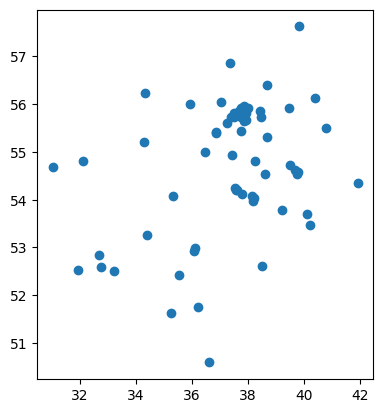

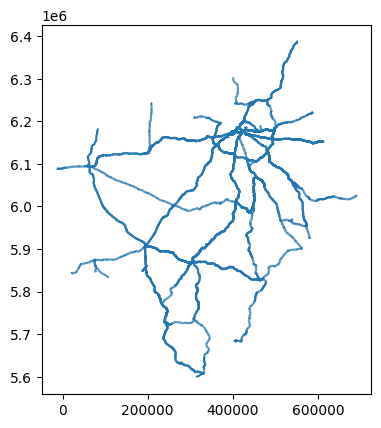

In [7]:
import matplotlib.pyplot as plt

shape2 = aggregated_data
shapefile.plot()
plt.show()

shape2.plot()
plt.show()


In [8]:
import geopandas as gpd

# Assuming your GeoDataFrame 'shapefile2' has a proper CRS set
# Calculate the length of each geometry in meters
aggregated_data['length_km'] = aggregated_data['geometry'].length / 1000

# Print the result
print(aggregated_data[['origin','destinatio','geometry', 'length_km', "maxspeed"]])

                    origin                     destinatio  \
0       Александро-Невская                         Рыбное   
1   Бекасово-Сортировочное                        Вековка   
2   Бекасово-Сортировочное          Люблино-Сортировочное   
3   Бекасово-Сортировочное                  Малоярославец   
4   Бекасово-Сортировочное  Москва-Сортировочная-Киевская   
..                     ...                            ...   
75                   Унеча                       Стародуб   
76                 Фрязево                        Ногинск   
77                 Щёлково               Лосиноостровская   
78       Ярославль-Главный               Лосиноостровская   
79       Ярославль-Главный                  Орехово-Зуево   

                                             geometry   length_km   maxspeed  
0   MULTILINESTRING ((580388.745 5926227.814, 5804...  207.117385       80.0  
1   MULTILINESTRING ((589802.650 6148604.962, 5897...  409.087282  81.370158  
2   MULTILINESTRING ((420474.2

In [9]:
import pandas as pd

In [10]:
train_df = pd.read_csv("/kaggle/input/rzhd-hack/dataset_external.csv")
train_df

,index,value,route_start,route_end
0,1198,4.150000,Кусково,Яничкино
1,2983,14.300000,Вековка,Курск
2,3418,7.116667,Люблино-Сортировочное,Рязань-2
3,1955,20.333333,Красное,Погар
4,1697,13.900000,Белгород,Елец
...,...,...,...,...
1514,2424,10.683333,Люберцы II,Волоколамск
1515,1364,9.166667,Волоколамск,Вековка
1516,1419,10.866667,Перово,Елец
1517,1723,9.483333,Волоколамск,Узуново


In [11]:
import geopandas as gpd
import networkx as nx


In [12]:
all_routes = aggregated_data


# Create an empty graph
G = nx.Graph()

# Add nodes (stations) to the graph
stations = set(all_routes['origin']).union(set(all_routes['destinatio']))
G.add_nodes_from(stations)

# Add edges (routes) to the graph with distance as weight
for index, row in all_routes.iterrows():
    G.add_edge(row['origin'], row['destinatio'], weight=row['length_km'])
    # Assuming undirected graph, add the reverse edge
    G.add_edge(row['destinatio'], row['origin'], weight=row['length_km'])
    
# Create an empty graph
F = nx.Graph()

# Add nodes (stations) to the graph
stations = set(all_routes['origin']).union(set(all_routes['destinatio']))
F.add_nodes_from(stations)

# Add edges (routes) to the graph with distance as weight
for index, row in all_routes.iterrows():
    F.add_edge(row['origin'], row['destinatio'], weight=row['length_km']/row['maxspeed'])
    # Assuming undirected graph, add the reverse edge
    F.add_edge(row['destinatio'], row['origin'], weight=row['length_km']/row['maxspeed'])


In [13]:
# Function to find shortest path between start and end stations
def find_shortest_path(start_station, end_station):
    try:
        if not(start_station in G and end_station in G):
            return 0,0,0
        else:
            shortest_path = nx.shortest_path(G, start_station, end_station, weight='weight')
            shortest_distance = nx.shortest_path_length(G, start_station, end_station, weight='weight')
            num_stations = len(shortest_path) - 1
            return shortest_path, shortest_distance, num_stations
    except nx.NetworkXNoPath:
        return None, float('inf'), float('inf')  # No path found

def find_fastest_path(start_station, end_station):
    try:
        if not(start_station in F and end_station in F):
            return 0,0,0
        else:
            fastest_path = nx.dijkstra_path(F, start_station, end_station, weight='weight')
            fastest_distance = nx.dijkstra_path_length(F, start_station, end_station, weight='weight')
            num_stations_fast = len(fastest_path) - 1
            return fastest_path, fastest_distance, num_stations_fast
    except nx.NetworkXNoPath:
        return None, float('inf'), float('inf')  # No path found

# Example: Iterate over train_df to find optimal paths
for index, row in train_df.iterrows():
    start_station = row['route_start']
    end_station = row['route_end']
    
    shortest_path, shortest_distance, num_stations = find_shortest_path(start_station, end_station)
    fastest_path, fastest_distance, num_stations_fast = find_fastest_path(start_station, end_station)
    
    if shortest_path:
        # Update train_df with optimal distance
        train_df.at[index, 'optimal_distance_km'] = shortest_distance
        train_df.at[index, 'num_stations'] = num_stations
    else:
        train_df.at[index, 'optimal_distance_km'] = 0  # or any default value for no path found
        train_df.at[index, 'num_stations'] = 0
    if fastest_path:
        # Update train_df with optimal distance
        train_df.at[index, 'optimal_distance_hours'] = fastest_distance
        train_df.at[index, 'num_stations_fast'] = num_stations_fast
    else:
        train_df.at[index, 'optimal_distance_hours'] = 0
        train_df.at[index, 'num_stations_fast'] = 0

# Print updated train_df
print(train_df)



      index      value            route_start    route_end  \
0      1198   4.150000                Кусково     Яничкино   
1      2983  14.300000                Вековка        Курск   
2      3418   7.116667  Люблино-Сортировочное     Рязань-2   
3      1955  20.333333                Красное        Погар   
4      1697  13.900000               Белгород         Елец   
...     ...        ...                    ...          ...   
1514   2424  10.683333             Люберцы II  Волоколамск   
1515   1364   9.166667            Волоколамск      Вековка   
1516   1419  10.866667                 Перово         Елец   
1517   1723   9.483333            Волоколамск      Узуново   
1518   1006   6.466667               Рязань-2       Перово   

      optimal_distance_km  num_stations  optimal_distance_hours  \
0              268.887101           2.0                3.123418   
1             1166.548994           5.0               13.957866   
2              314.678247           2.0               

In [14]:
test_df = pd.read_csv("/kaggle/input/rzhd-hack/dataset_internal.csv")

In [15]:
# Example: Iterate over train_df to find optimal paths
for index, row in test_df.iterrows():
    start_station = row['route_start']
    end_station = row['route_end']
    
    shortest_path, shortest_distance, num_stations = find_shortest_path(start_station, end_station)
    fastest_path, fastest_distance, num_stations_fast = find_fastest_path(start_station, end_station)
    
    if shortest_path:
        # Update train_df with optimal distance
        test_df.at[index, 'optimal_distance_km'] = shortest_distance
        test_df.at[index, 'num_stations'] = num_stations
    else:
        test_df.at[index, 'optimal_distance_km'] = 0  # or any default value for no path found
        test_df.at[index, 'num_stations'] = 0
    if fastest_path:
        # Update train_df with optimal distance
        test_df.at[index, 'optimal_distance_hours'] = fastest_distance
        test_df.at[index, 'num_stations_fast'] = num_stations_fast
    else:
        test_df.at[index, 'optimal_distance_hours'] = 0
        test_df.at[index, 'num_stations_fast'] = 0

# Print updated train_df
print(test_df)


      index                 route_start               route_end  \
0      2623                      Вязьма                 Щёлково   
1      4413                    Аэропорт                   Лесок   
2       480                     Узуново           Малоярославец   
3      4409                    Серпухов                   Лесок   
4      9286                  Кунцево II                 Петушки   
...     ...                         ...                     ...   
1514   1676                        Елец                  Перово   
1515   8047                 Зелёный Бор                 Вековка   
1516     37  Москва-Товарная-Смоленская            Курбакинская   
1517   1179      Смоленск-Сортировочный                Владимир   
1518   8020                    Аэропорт  Бекасово-Сортировочное   

      optimal_distance_km  num_stations  optimal_distance_hours  \
0              757.835709           4.0                8.905591   
1                0.000000           0.0                0.0000

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv

# Assuming 'optimal_distance_km' is the target variable
X = train_df.drop(columns=["index",'value'])  # Features
y = train_df['value']  # Target variable

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.001, random_state=42)


In [17]:
# Define CatBoost parameters
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': "RMSE",
    'random_seed': 42
}

# Convert data to CatBoost Pool format
train_pool = Pool(data=X_train, label=y_train, cat_features = ['route_start',"route_end"])
val_pool = Pool(data=X_val, label=y_val, cat_features = ['route_start',"route_end"])

# Perform cross-validation
cv_results = cv(pool=train_pool,
                params=catboost_params,
                fold_count=5,  # Number of folds for cross-validation
                verbose=100,  # Print progress every 100 iterations
                plot=True)  # Plot training metrics

# Get best iteration
best_iteration = len(cv_results)  # Use the number of iterations where the best metric was achieved

print(f"Best RMSE: {cv_results['test-RMSE-mean'].min():.2f} ± {cv_results['test-RMSE-std'].mean():.2f} at iteration {best_iteration}")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 10.8896251	test: 10.9263952	best: 10.9263952 (0)	total: 56.5ms	remaining: 56.5s
100:	learn: 1.9059503	test: 1.9028086	best: 1.9028086 (100)	total: 251ms	remaining: 2.23s
200:	learn: 1.5778690	test: 1.8199833	best: 1.8191417 (194)	total: 488ms	remaining: 1.94s
300:	learn: 1.3596123	test: 1.7925291	best: 1.7906516 (292)	total: 678ms	remaining: 1.57s
400:	learn: 1.1969162	test: 1.7502974	best: 1.7486164 (398)	total: 872ms	remaining: 1.3s
500:	learn: 1.0824322	test: 1.7357656	best: 1.7345681 (495)	total: 1.08s	remaining: 1.07s
600:	learn: 0.9807351	test: 1.7235153	best: 1.7230475 (592)	total: 1.27s	remaining: 844ms
700:	learn: 0.8936599	test: 1.7310502	best: 1.7222131 (622)	total: 1.47s	remaining: 625ms
800:	learn: 0.8056086	test: 1.7184986	best: 1.7162639 (771)	total: 1.65s	remaining: 410ms
900:	learn: 0.7424940	test: 1.7152864	best: 1.7145231 (895)	total: 1.84s	remaining: 202ms
999:	learn: 0.6955338	test: 1.7195898	best: 1.7145231 (895)	total: 2.05s	remai

In [18]:
# Initialize CatBoostRegressor with best parameters
best_model = CatBoostRegressor(iterations=best_iteration,
                               learning_rate=0.1,
                               depth=6,
                               loss_function='RMSE',
                               random_seed=42)
train_pool = Pool(data=X, label=y, cat_features=['route_start',"route_end"])
best_model.fit(train_pool,verbose=100)  # Verbose to see progress every 100 iterations

0:	learn: 4.3587204	total: 3.26ms	remaining: 3.26s
100:	learn: 1.8706414	total: 184ms	remaining: 1.64s
200:	learn: 1.5291200	total: 360ms	remaining: 1.43s
300:	learn: 1.3344046	total: 540ms	remaining: 1.25s
400:	learn: 1.1900251	total: 721ms	remaining: 1.08s
500:	learn: 1.0783804	total: 902ms	remaining: 899ms
600:	learn: 0.9858296	total: 1.08s	remaining: 716ms
700:	learn: 0.9092105	total: 1.26s	remaining: 536ms
800:	learn: 0.8369339	total: 1.44s	remaining: 357ms
900:	learn: 0.7751509	total: 1.61s	remaining: 177ms
999:	learn: 0.7244089	total: 1.79s	remaining: 0us


In [19]:
# Predict on test data
y_pred = best_model.predict(X_val)

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE and MAE
rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)

print(f"RMSE: {rmse:.2f} hours")
print(f"MAE: {mae:.2f} hours")


RMSE: 1.24 hours
MAE: 1.10 hours


In [20]:
test_pool = Pool(data=test_df, cat_features=['route_start',"route_end"])

# Assuming 'test_df' has similar structure as 'train_df' without 'optimal_distance_km'
test_pred = best_model.predict(test_pool)

# Print or use 'test_pred' as needed for your application
print(test_pred)

[11.27662385 10.48331108 11.29047846 ... 13.43879574  9.79160624
 11.12657793]


In [21]:
test_csv = pd.read_csv("/kaggle/input/rzhd-hack/dataset_internal.csv")
test_csv

,index,route_start,route_end
0,2623,Вязьма,Щёлково
1,4413,Аэропорт,Лесок
2,480,Узуново,Малоярославец
3,4409,Серпухов,Лесок
4,9286,Кунцево II,Петушки
...,...,...,...
1514,1676,Елец,Перово
1515,8047,Зелёный Бор,Вековка
1516,37,Москва-Товарная-Смоленская,Курбакинская
1517,1179,Смоленск-Сортировочный,Владимир


In [22]:
test_csv["value_predict"] = test_pred

In [23]:
test_csv.to_csv("cb_predict.csv")